# Analiza funkcji przydzielającej wartość dopasowania danego tekstu do języka

### Definicja funkcji lang_confidence_score
Funkcja oblicza stosunek liczby wystąpień słów tekstu znajdujących się w liście najpopularniejszych słów danego języka do całkowitej liczby słów w tekście.


In [53]:
def lang_confidence_score(word_counts, language_words_with_frequency):
    number_of_words_from_language = 0
    total_number_of_words = 0
    # create a set of dictionary keys (lowercase)
    set_of_language_words = {w.lower() for w in language_words_with_frequency}

    for word, count in word_counts.items():
        total_number_of_words += count
        if word.lower() in set_of_language_words:
            number_of_words_from_language += count
    return number_of_words_from_language / total_number_of_words if total_number_of_words > 0 else 0.0

### Pobieranie najczęstszych słów dla języków
Pobieramy listę 1000 najczęściej używanych słów dla języka angielskiego (en), polskiego (pl) i francuskiego (fr) z pakietu `wordfreq`.
Tworzymy słownik, który dla każdego języka trzyma listę najpopularniejszych słów.

In [ ]:
from wordfreq import top_n_list
languages_codes = ['en', 'pl', 'fr']
MAX_K = 1000
# create a dictionary with a sorted list of words for each language
lang_top_words = {code: top_n_list(code, MAX_K) for code in languages_codes}

### Przygotowanie artykułów z Bulbapedii w języku angielskim
Pobieramy dwa artykuły z Bulbapedii
1. Dłuższy artykuł o "Bulbasaur"
2. Artykuł "List of Japanese Pokémon names", który jest przykładem tekstu o niskim wyniku dopasowania do języka angielskiego (dużo nazw własnych (nazwy pokemonów)).

In [ ]:
from scraper_class import Scraper
long_wiki_scraper = Scraper(
    wiki_url="https://bulbapedia.bulbagarden.net/wiki",
    phrase="Bulbasaur"
)
long_wiki_counts = long_wiki_scraper.count_words()

low_wiki_scraper = Scraper(
    wiki_url="https://bulbapedia.bulbagarden.net/wiki",
    phrase="List of Japanese Pokémon names"
)
low_wiki_counts=low_wiki_scraper.count_words()

Sprawdźmy poziom dopasowania z językiem angielskim dla tych artykułów:

In [81]:
print(f"Dopasowanie dla artykułu 'Bulbasaur': {lang_confidence_score(long_wiki_counts, lang_top_words['en'])}")
print(f"Dopasowanie dla artykułu 'List of Japanese Pokémon names': {lang_confidence_score(low_wiki_counts, lang_top_words['en'])}")

Dopasowanie dla artykułu 'Bulbasaur': 0.44244604316546765
Dopasowanie dla artykułu 'List of Japanese Pokémon names': 0.058697444352844186


**Skąd tak niski wynik dla angielskiego artykułu?** Zwróćmy uwagę, że Bulbapedia jest specyficznym wiki skupiającym się na głównie na niesistniejących w rzeczywiśtości krainach, zdarzeniach, stworzeniach itp. W związku z tym jej artykuły w dużej mierze zawierają zmyślone nazwy i słowa niewystępujące oficjalnie w językach, które są używane bardzo rzadko w porównaniu z naturalnymi słowami. Wiedząc to, znalezienie artykułu który mimo, że teoretycznie jest w języku angielskim ,ale który miałby niskie dopasowanie z tym językiem było łatwe, ponieważ polegało na znalezieniu artykułu który jest listą jakichś nieistniejących rzeczywiście obiektów. W tym przypadku są to nazwy pokémonów.



### Pobieranie tekstów spoza Bulbapedii
Definiujemy funkcję `get_books_counts`, która pobiera tekst książki z serwisu https://www.gutenberg.org oraz ucina automatyczne informacje dodane do treści książki po czym zwraca obiekt Counter, który dla każdego słowa (znormalizowanego do małych liter i z usuniętymi znakami interpunkcyjnymi) przechowuje liczbę wystąpień w książcę. Czyszczenie tekstu jest szczególnie ważne, ponieważ początkowe i końcowe komentarze są napisane w języku angielskim co zaburza analizę językową.


In [ ]:
import requests
from collections import Counter
import re

def get_books_counts(url):
    response = requests.get(url)
    response.encoding = 'utf-8' # For non-english characters

    full_text = response.text
    # Delete automatically added English phrases from the text
    start_marker = "*** START OF THE PROJECT"
    end_marker = "*** END OF THE PROJECT"

    start_index = 0
    start_marker_position = full_text.find(start_marker)
    if start_marker_position != -1:
        # end of the *** START OF THE ... *** line
        start_index = full_text.find("\n", start_marker_position) + 1

    end_index = len(full_text)
    end_marker_position = full_text.find(end_marker)
    if end_marker_position != -1:
        end_index = end_marker_position

    # get text without English description
    real_text = full_text[start_index:end_index]

    # convert text to lowercase
    raw_text = real_text.lower()
    raw_words = raw_text.split()
    words = []
    for word in raw_words:
        # Remove punctuation from the end and beginning of the words
        cleaned = re.sub(r'^\W+|\W+$', ' ', word, flags=re.UNICODE).strip()
        if cleaned:
            words.append(cleaned)
    return Counter(words)


### Pobieranie konkretnych książek w różnych językach
Pobieramy "Pana Tadeusza" (w języku polskim), "Robinsona Crusoe" (w języku angielskim) oraz "Dwadzieścia tysięcy mil podmorskiej żeglugi" (w języku francuskim).


In [ ]:
books_texts_counts = {
    "pl": get_books_counts("https://www.gutenberg.org/cache/epub/31536/pg31536.txt"),
    "en": get_books_counts("https://www.gutenberg.org/cache/epub/70841/pg70841.txt"),
    "fr": get_books_counts("https://www.gutenberg.org/cache/epub/54873/pg54873.txt")
}


### Obliczanie wyników dla różnych wartości k
Obliczamy wyniki funkcji `lang_confidence_score` dla każdej trójki: (badany język, liczba wystąpień słów w tekście, lista k najczęstszych słów w badanym języku)

In [ ]:
import pandas as pd

results_for_texts = [
    {"name": "Bulbasaur (EN, duże wiki)", "counts": long_wiki_counts},
    {"name": "List of Japanese Pokémon names  (EN, trudne wiki)", "counts": low_wiki_counts},
    {"name": "Pan Tadeusz (PL)", "counts": books_texts_counts['pl']},
    {"name": "Robinson Crusoe (EN)", "counts": books_texts_counts['en']},
    {"name": "Dwadzieścia Tysięcy Mil Podmorskiej Żeglugi (FR)", "counts": books_texts_counts['fr']}
]

languages = ['en', 'pl', 'fr']
k_values = [3, 10, 100, 1000]
data = []

for result in results_for_texts:
    for lang in languages:
        for k in k_values:
            top_k_words = lang_top_words[lang][:k]
            score = lang_confidence_score(result["counts"], top_k_words)
            data.append({
                "Nazwa Tekstu": result["name"],
                "Język": lang,
                "Wynik": score,
                "k": k
            })
df = pd.DataFrame(data)


### Wizualizacja wyników
Definiujemy funkcję `create_chart`, która generuje wykres słupkowy dla danej wartości `k`, przedstawiając wyniki dopasowania dla różnych tekstów i języków.


In [ ]:
import matplotlib.pyplot as plt

def create_chart(dataframe, k_val):
    df_for_k = dataframe[df['k'] == k_val]
    df_plot = df_for_k.pivot(index='Nazwa Tekstu', columns='Język', values='Wynik')
    df_plot.plot(kind='bar', figsize=(8, 5), color=['blue', 'green', 'red'])
    plt.ylim(0,1) # Strict limits of Y axis
    plt.title(f"Dopasowanie języka dla k = {k_val}")
    plt.ylabel("Wynik dopasowania [0..1]")
    plt.xticks(rotation=20, ha='right') # Rotate text names
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


### Generowanie wykresów
Poniżej znajdują się wykresy dla kolejnych wartości `k`


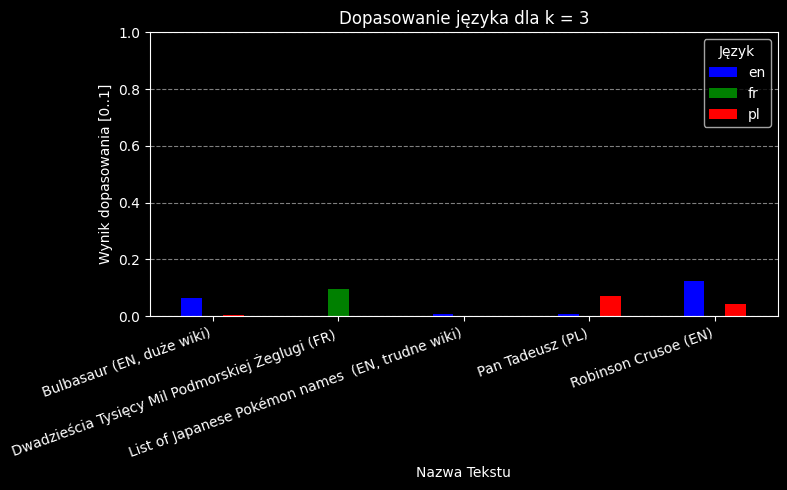

In [82]:
create_chart(df, 3)


Dla **k=3** (tylko 3 najpopularniejsze słowa w danym języku) wykres pokazuje że wartości dopasowania są niskie (nie przekraczają 0.2) dla wszystkich kombinacji języka i tekstu. Można zauważyć że każdy tekst poza trudnym artykułem ma wyraźnie największe dopasowanie ze swoim rzeczywistym językiem. W przypadku trudnego artykułu z większością nazw własnych dla każdego języka te wartości są bliskie zeru. Dodatkowo zauważyć można, że wyłacznie natywnie francuski tekst ma niezerową zgodność z językiem francuskim oraz natywnie francuski tekst ma zerowe dopasowanie z każdym z obcych języków. Zauważalny poziom dopasowania tekstów angielskich z językiem polskim wynika z faktu, że niektóre z najpopularniejszych słów języka angielskiego występują często w języku polskim.

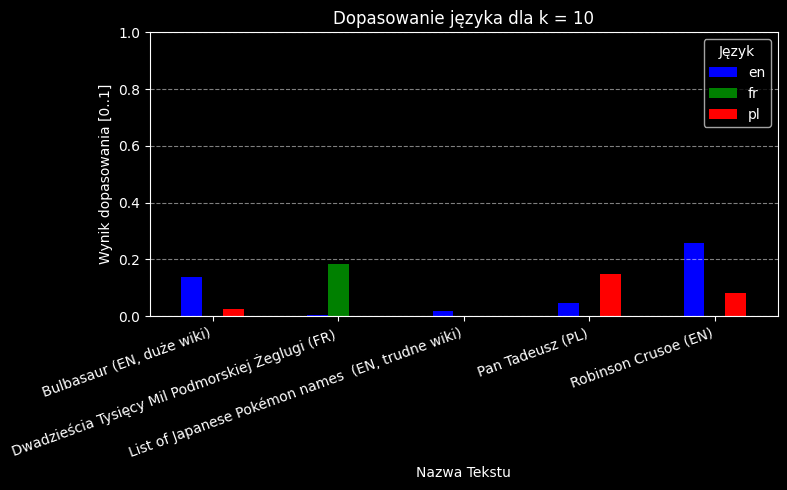

In [83]:
create_chart(df, 10)


Dla **k=10** (10 najpopularniejszych słów w danym języku) wyraźnie widać wzrost dopasowania dla tekstów z ich rzeczywistymi językami. W każdym prawie przypadku (poza trudnym artykułem dla którego wszystkie wartości są bliskie zeru) różnica pomiędzy dopasowaniem dla języka rzeczywistego a dopasowaniami dla języków obcych się zwiększyła. W dalszym ciągu francuski tekst ma niezerowe dopasowanie wyłącznie z językiem francuskim oraz teskty w innych językach nie mają dopasowania z językiem francuskim.

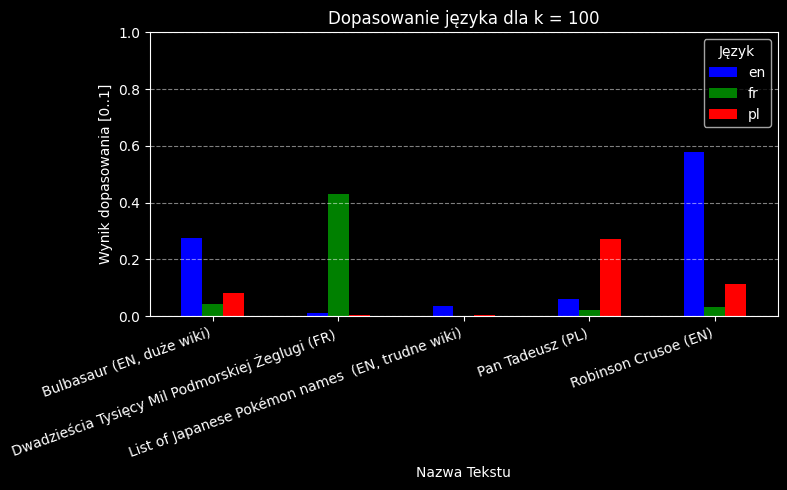

In [84]:
create_chart(df, 100)


Dla **k=100** (100 najpopularniejszych słów w danym języku) Różnice dopasowań tekstów do ich rzeczywistych języków jeszcze wyraźniej odbiegają od dopasowań do języków obcych. Zaczęły pojawiać się niewielkie dopasowania między językiem francuskim a tekstami w innych językach. Teraz wyraźnie widać że teskt natywnie polski ma dopasowanie do języka polskiego na poziomie 0.30 podczas gdy tekst francuski ma z językiem francuskim ponad 0.4, a tekst angielski z językiem angielskim ma prawie 0.6.

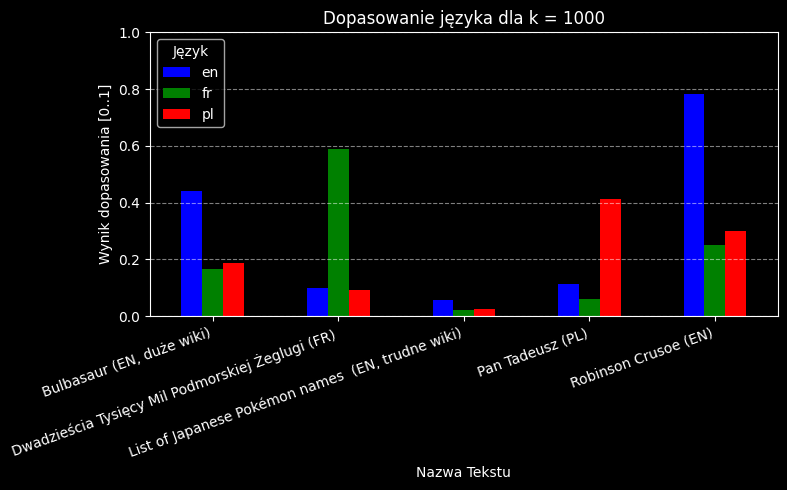

In [85]:
create_chart(df, 1000)

Dla **k=1000** (1000 najpopularniejszych słów w danym języku) Wyraźnie widać, że spośród dopasowań długiego tekstu ze swoim natywnym językiem, język polski osiąga zdecydowanie najniższe wyniki (Pan Tadeusz ma dopasowanie z językiem polskim na poziomie 0.4). Bardzo zauważalne są względnie wysokie dopasowania tekstów angielskich do języka polskiego oraz francuskiego (dla Robinsona Crusoe na poziomie 0.3) chociaż mimo tego, dopasowania tekstów z ich natywnymi językami są znacząco większe od dopasowań z innymi językami (poza trudnym artykułem, który tak naprawdę zawiera pdoobną ilośc słów w każdym z badanych języków, gdyż w większości posiada słowa niewystępujące w żadnym z tych języków)


### Wnioski


**Skuteczność metody `lang_confidence_score`**: Dla każdego testowanego k, każdy tekst miał największe dopasowanie ze swoim natywnym językiem co sugeruje pewną skuteczność zaproponowanej metody do mierzenia dopasowań z językiem. Jednak zauważalnym problemem jest przypisywanie względnie wysokich dopasowań tekstu do języków obcych dla dużego k. Np "Robinson Crusoe" napisany w języku angielskim dla k=1000 ma dopasowanie z językiem polskim na poziomie 0.3, a "Pan Tadeusz" napisany w języku polskim ma dopasowanie niewiele większe niz 0.4. Mimo że dla większych k, dopasowania tekstu do jego natywnego języka są znacznie większe niż dopasowania tego tekstu do języków obcych, to tak bliskie wartości (jak te opisane dla "Pana Tadeusza" i "Robinsona Crusoe") sugerują, że dla pewnych danych wyniki funkcji mogą być niewiarygodne.

**Znaczenie tekstu w analizie**: Na przykładzie dopasowania artykułu z Bulbapedii o Bulbasaurze oraz "Robinsonie Crusoe" z językiem angielskim można zauważyć, że choć obydwa teksty były teoretycznie napisane w tym samym języku to dopasowanie dla "Robinsona Crusoe" jest znacznie wyższe (dla k=1000 jest to około 0.8, a dla artykułu z wiki mniej niż 0.5). Wynika to z tego, że w artykule na wiki występuje wiele nazw własnych które nie występują w języku angielskim i ich duża ilość zmniejsza stosunek słów rzeczywiście występujących w języku angielskim do wszystkich słów występujących w tekście. Świadczy to o dużym znaczeniu doboru tekstu dla precyzji analizy z użyciem badanej funkcji.

**Znaczenie doboru języków**: Dobór języków ma duże znaczenie dla analizy języka tekstu. Na podstawie wszystkich wykresów możemy zauważyć, że teksty angielskie mają względnie wysokie dopasowanie z językiem polskim oraz teksty polskie z językiem angielskim. Dzieje się tak ponieważ w obydwu tych językach popularne są słowa pisane tak samo np. "i" oraz "a". Dla kontrastu tekst dla k równych 3,10 lub 100. Miał dopasowania bliskie zeru z językiem angielskim oraz polskim, a teksty w językach angielskim i polskim miały praktycznie zerowe dopasowania z językiem francuskim.

**Wnoski na temat częstości odmieniania słów**: Zauważmy, że mimo że "Pan Tadeusz" jest napisany w języku polskim to jego dopasowanie (dla k=1000) z natywnym językiem równe około 0.4 jest zauważalnie mniejsze niż dopasowanie "Robinsona Crusoe" (ok. 0.8) napisanego w języku angielskim z jego natywnym językiem. Jest to wynik tego, że słowa w języku polskim porpzez bogatą odmianę mają równiej rozłożone częstotliwości występowania (odniesienie do tego samego stanu w języku polskim jest realizowane za pomocą wielu słów różniących się jedynie odmianą). Dlatego słowo odnoszące się do tego samego w języku polskim może mieć nawet kilkukrotnie mniejszą częstotliwość niż agnielski odpowiednik. Sugeruje to, że języki dla których teksty w nich napsiane mają niższe wartości dopasowania mają bogatszą odmianę słów.